In [1]:
# Set google drive folder to working directory

from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('gdrive/My Drive/Colab Notebooks/ml_engineer/supervised_learning/project')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for CharityML
## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features.

The dataset for this project originates from the UCI Machine Learning Repository. The datset was donated by Ron Kohavi and Barry Becker, after being published in the article "Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid". You can find the article by Ron Kohavi online. The data we investigate here consists of small changes to the original dataset, such as removing the 'fnlwgt' feature and records with missing or ill-formatted entries.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, 'income', will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [0]:
# Importing libraries
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import warnings
import visuals as vs

%matplotlib inline
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")

In [3]:
# Loading the census data
data = pd.read_csv('./data/census.csv')

data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


## Data Exploration:
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. Some important information:
* The total number of records
* The number of individuals making more than \$50,000 annualy
* The number of individuals making at most \$50,000 anually
* The percentage of individuals making more than $50,000 anually

In [4]:
data['income'].unique()

array(['<=50K', '>50K'], dtype=object)

In [5]:
# Total number of records
n_records = data.shape[0]

# > $50k
n_greater_50k = data[data.income == '>50K'].shape[0]

# <= $50k
n_at_most_50k = data[data.income == '<=50K'].shape[0]

# % of > 50k
greater_percent = n_greater_50k / n_records * 100

print('Total number of records: {}'.format(n_records))
print('Individuals making more than $50k: {}'.format(n_greater_50k))
print('Individuals making at most $50k: {}'.format(n_at_most_50k))
print('Percentage of individuals making more than $50k: {:.2f}%'.format(greater_percent))

Total number of records: 45222
Individuals making more than $50k: 11208
Individuals making at most $50k: 34014
Percentage of individuals making more than $50k: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

## Preparing the Data:
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. In this dataset, two features fit this description: `capital-gain` and `capital-loss`.

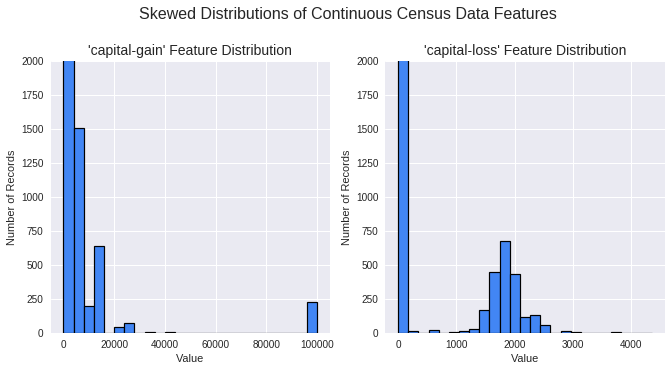

In [6]:
fig = plt.figure(figsize = (11,5))

for i, feature in enumerate(['capital-gain','capital-loss']):
    ax = fig.add_subplot(1,2,i+1)
    ax.hist(data[feature], bins = 25, color = '#4286f4', edgecolor='black', linewidth=1.2)
    ax.set_title("'%s' Feature Distribution" % (feature), fontsize = 14)
    fig.suptitle('Skewed Distributions of Continuous Census Data Features', fontsize = 16, y = 1.03)
    ax.set_xlabel('Value')
    ax.set_ylabel('Number of Records')
    ax.set_ylim((0,2000))
    ax.set_yticks([0,500,1000,1500,2000],[0,500,1000,1500,'>2000'])

plt.show()

For highly-skewed feature distributions such as `capital-gain` and `capital-loss`, it's commom applying <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the dat, so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the logarithm successfully.

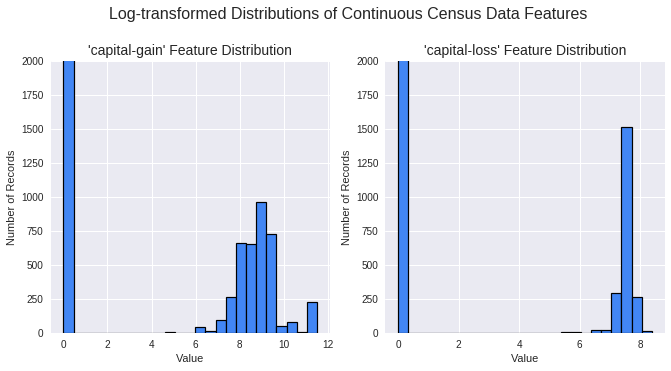

In [7]:
# Split the data into features and target label
income_raw   = data['income']
features_raw = data.drop('income', axis = 1)

# Log-transform the sweked features
skewed       = ['capital-gain','capital-loss']
feature_log_transformed          = pd.DataFrame(data = features_raw)
feature_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))


fig = plt.figure(figsize = (11,5))

for i, feature in enumerate(['capital-gain','capital-loss']):
    ax = fig.add_subplot(1,2,i+1)
    ax.hist(feature_log_transformed[feature], bins = 25, color = '#4286f4', edgecolor='black', linewidth=1.2)
    ax.set_title("'%s' Feature Distribution" % (feature), fontsize = 14)
    fig.suptitle('Log-transformed Distributions of Continuous Census Data Features', fontsize = 16, y = 1.03)
    ax.set_xlabel('Value')
    ax.set_ylabel('Number of Records')
    ax.set_ylim((0,2000))
    ax.set_yticks([0,500,1000,1500,2000],[0,500,1000,1500,'>2000'])

plt.show()

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `capital-gain` or `capital-loss` above). However, normalization ensures that each feature is treated equally when applying supervised learning algorithms. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as the example below.

We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Initializing a scaler and applying to the features
scaler    = MinMaxScaler() # default (0,1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform            = pd.DataFrame(data = feature_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(feature_log_transformed[numerical])

features_log_minmax_transform.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


## Implementation:
### Data Preprocessing

From the first table, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called _categorical variables_) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a "dummy" variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B` or `C`. Then we encode this feature into `someFeature_A`, `someFeature_B`, and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label `income` to numerical values for the algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`. 

* Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform  one-hot encoding on the the `features_raw` data.
* Convert the target label `income_raw` to numerical entries.
  * Set records with "<=50K" to 0 and records with ">50K" to 1.

In [9]:
# One-hot encoding features_log_minmax_transform data
features_final = pd.get_dummies(features_log_minmax_transform)

# Encoding income_raw data to numerical values
income = income_raw.map({'<=50K': 0, '>50K':1})

encoded = list(features_final.columns)
print('{} total features after one-hot encoding.'.format(len(encoded)))

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and the others for testing.

In [10]:
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, income, test_size = .2, random_state = 42)

print('Training set has {} samples.'.format(X_train.shape[0]))
print('Testing set has {} samples.'.format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


## Evaluating Model Performance
We will investigate four different algorithms, and determine which is the best at modeling the data. Three will be supervised learning algorithms of our choice, and the fourth is known as a _naive predictor_.



### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

In [11]:
TP = np.sum(income)       # Counting the ones as this is the naive case
FP = income.count() - TP  # Specific to the naive case
TN = 0                    # No predicted negatives in the naive case
FN = 0                    # No predicted negatives in the naive case

accuracy  = TP / n_records
recall    = TP / (TP + FN)
precision = TP / (TP + FP)
fscore    = (1 + .5**2) * (precision * recall) / ((.5**2 * precision) + recall)

print("Naive Predictor: [Accuracy Score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy Score: 0.2478, F-score: 0.2917]


### Supervised Learning Models

**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html):
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model, it's important to create a training and predicting pipeline that allows to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. See below a brief pipeline:
* Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
* Fit the algorithm to the sampled training data and record the training time.
* Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`
    * Record the total prediction time
* Calculate the accuracy score for both the training subset and testing set.
* Calculate the F-Score for both the training subset and testing set.
    * Make sure that we set the beta parameter.

In [0]:
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(model, sample_size, X_train, y_train, X_test, y_test):    
    '''
    inputs:
      - model: the learning algorithm to be trained and predicted on
      - sample_size: number of samples to be drawn for the training set
      - X_train: features from training set
      - y_train: target feature from training set
      - X_test: features from test set
      - y_test: target feature from test set
    '''
    
    results = {}
    
    # Fit the model to the training data using slicing with 'sample_size'
    start = time()
    clf   = model.fit(X_train[:sample_size], y_train[:sample_size])
    end   = time()
    
    # Calculate the training time
    results['train_time'] = end - start
    
    # Get the predictions on the test set then get the predictions on the first 300 training samples
    start             = time()
    pred_test  = clf.predict(X_test)
    pred_train = clf.predict(X_train[:sample_size])
    end               = time()
    
    # Calculate the prediction time
    results['pred_time'] = end - start
    
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:sample_size], pred_train)
    
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, pred_test)
    
    # Compute F-Score on the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:sample_size], pred_train, beta = .5)
    
    # Compute F-Score on test set
    results['f_test'] = fbeta_score(y_test, pred_test, beta = .5)
    
    print('{} trained on {} samples.'.format(model.__class__.__name__, sample_size))
    
    return results

### Initial Model Evaluation

* Import the supervised learning models.
* Initialize them and store in `clf_A`, `clf_B` and `clf_C`.
    * Use a `random_state` for each model.
    * **Note:** Use the default settings for each model - we'll tune later.
* Calculate the number of records equal to 1%, 10% and 100% of the training data.
    * Store those values in `samples_1`, `samples_2`, and `samples_3` respectively.
    
**Note:** Depending on which algorithms we choose, the following implementation may take tome time to run

In [13]:
# Importing the models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.svm import SVC
from xgboost import XGBClassifier

# Initializing the models
clf_A = LogisticRegression()
clf_B = GradientBoostingClassifier()
#clf_C = SVC()
clf_D = XGBClassifier()

# Calculate the number of samples
samples_100 = len(y_train)
samples_10  = int(len(y_train) * .1)
samples_1   = int(len(y_train) * .01)

# Collecting the results on the models
results = {}
for clf in [clf_A, clf_B, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
XGBClassifier trained on 361 samples.
XGBClassifier trained on 3617 samples.
XGBClassifier trained on 36177 samples.


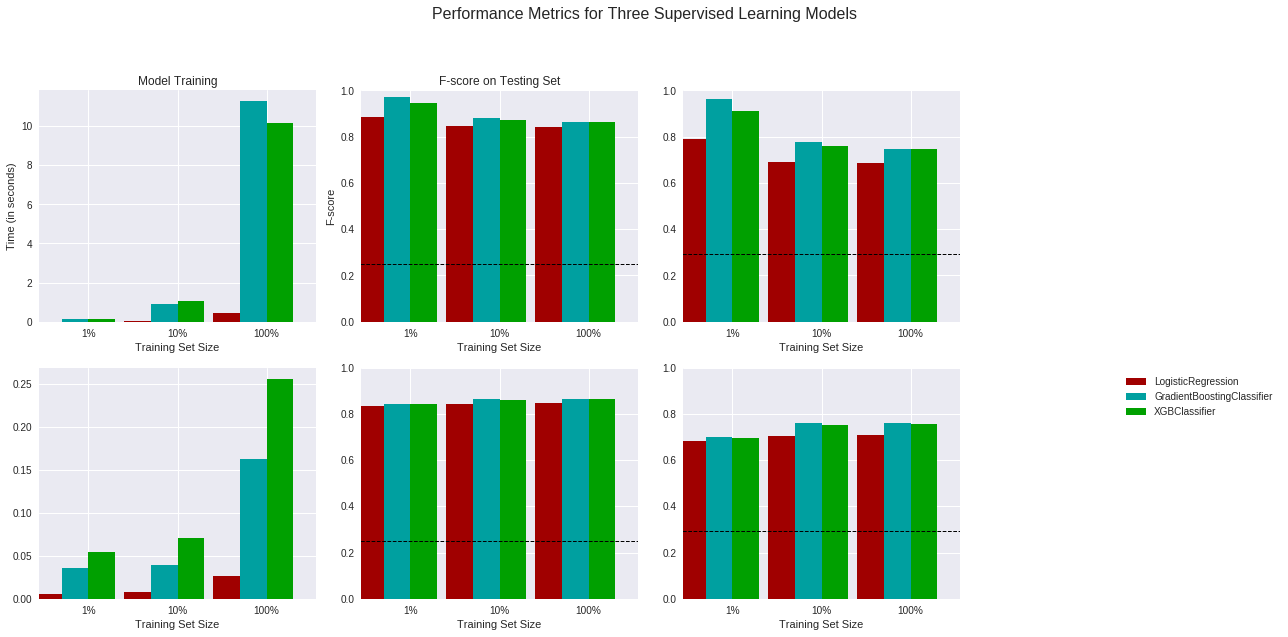

In [14]:
# Run metrics visualizations for the three models

# Create figure
fig, ax = plt.subplots(2, 4, figsize = (18,8))

# Constants
bar_width = .3
colors = ['#A00000','#00A0A0','#00A000']

# Super loop to plot four panels of data
for k, model in enumerate(results.keys()):
  for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
    for i in np.arange(3):
      ax[j//3, j%3].bar(i+k*bar_width, results[model][i][metric], width = bar_width, color = colors[k])
      ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
      ax[j//3, j%3].set_xticklabels(['1%', '10%', '100%'])
      ax[j//3, j%3].set_xlabel('Training Set Size')
      ax[j//3, j%3].set_xlim((-0.1, 3.0))

# Add unique y-labels
ax[0,0].set_ylabel('Time (in seconds)')
ax[0,1].set_ylabel('Accuracy Score')
ax[0,1].set_ylabel('F-score')
ax[0,1].set_ylabel('Time (in seconds)')
ax[0,1].set_ylabel('F-score')

# Add titles
ax[0,0].set_title('Model Training')
ax[0,1].set_title('Accuracy Score on Training Subset')
ax[0,1].set_title('F-score on Training Subset')
ax[0,1].set_title('Accuracy Score on Testing Set')
ax[0,1].set_title('F-score on Testing Set')

# Add horizontal lines for naive predictors
ax[0,1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[1,1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[0,2].axhline(y = fscore, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[1,2].axhline(y = fscore, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')

# Set y-limits for score panels
ax[0,1].set_ylim((0,1))
ax[0,2].set_ylim((0,1))
ax[1,1].set_ylim((0,1))
ax[1,2].set_ylim((0,1))

# Set additional plot invisibles
ax[0,3].set_visible(False)
ax[1,3].axis('off')

# Create legend
for i, model in enumerate(results.keys()):
  plt.bar(0, 0, color = colors[i], label = model)
  plt.legend()

# Aesthetics
plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
plt.tight_layout()
plt.show()

## Improving Results
Choose from the three models _the best model_ to use on the student data. We'll perform a search grid optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F_score.
It's important to look F-score on test set when 100% of training set is used and choose the model with highest score.
See some important points to choose a model:
* metrics - F-score on the testing set when 100% of training set is used.
* prediction/training time
* the algorithm's suitability for the data.

After that, describe the Model in Layman's Terms: 
* In one to two paragraphs, explain to CharityML, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

### Model Tuning
Fine tune your chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least three different values. You need to use the entire training set for this and implement the following :
* Import [`sklearn.grid_search.GridSearchCV`](https://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
* Initialize the classifier.
  * Set a random state to the same state you set before.
* Create a dictionary of parameters you wish to tune for the chosen model.
  * Example: `parameters` = { 'parameter' : [`list of values`] }
  * **Note:** Avoid tuning the `max_features` parameter of your model if that parameter is available!
* Use `make_scorer` to create a `fbeta_score` scoring object (with $\beta = 0.5$).
* Perform grid search on the classifier using the `scorer` and store it in `grid_obj`.
* Fit the grid search object to the training set data (`X_train` and `y_train`)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = XGBClassifier()

# Create the parameters list to tune
parameters = {
    'learning_rate':np.arange(1,4)
}

# Make a fbeta_score scoring
scorer = make_scorer(fbeta_score, beta = .5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring = scorer, cv = 3)

# Fit the grid search object to the training data and fit the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
pred      = (clf.fit(X_train, y_train)).predict(X_test)
best_pred = best_clf.predict(X_test)

# Report the before-and-after scores
print('\nUnoptimized model\n------')
print('Accuracy score on testing data: {:.4f}'.format(accuracy_score(y_test, pred)))
print('F-score on testing data: {:.4f}'.format(fbeta_score(y_test, pred, beta = .5)))
print('\nOptimized Model\n------')
print('Final accuracy score on the testing data: {:.4f}'.format(accuracy_score(y_test, best_pred)))
print('Final F-score on the testing data: {:.4f}'.format(fbeta_score(y_test, best_pred, beta = .5)))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Unoptimized model
------
Accuracy score on testing data: 0.8618
F-score on testing data: 0.7569

Optimized Model
------
Final accuracy score on the testing data: 0.8701
Final F-score on the testing data: 0.7634


## Feature Importance
An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than $\$50000$.

### Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute available for it. This attribute is a function that ranks the importance of each feature when making predictions based on chosen algorithm.
You'll need to implement:
* Import a supervised learning model from `sklearn` if its different from the three used earlier.
* Train the supervised model on the entire training set.
* Extract the feature importances using `.feature_importances_`.

In [0]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier(random_state = 42, n_estimators = 500).fit(X_train, y_train)

# Extract the feature importances using .feature_importances_
importances = model.feature_importances_

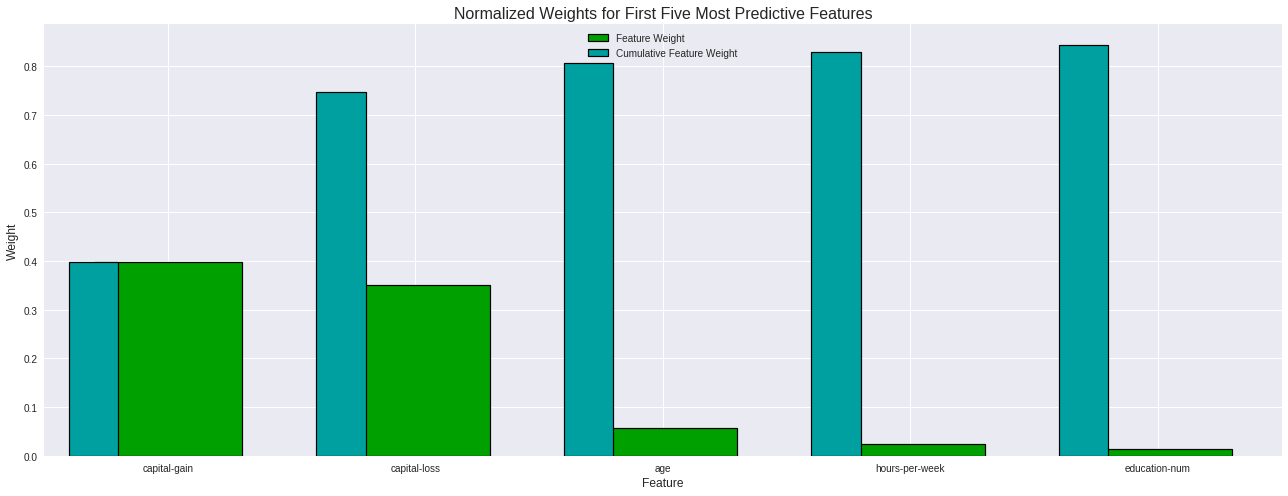

In [17]:
# Plot

# Display five most important features
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:5]]
values  = importances[indices][:5]

# Create the plot
fig = plt.figure(figsize = (18,7))
plt.title('Normalized Weights for First Five Most Predictive Features', fontsize = 16)
plt.bar(np.arange(5), values, width = .6, align = 'center', color = '#00A000', label = 'Feature Weight', edgecolor='black', linewidth=1.2)
plt.bar(np.arange(5) - .3, np.cumsum(values), width = .2, align = 'center', color = '#00A0A0', label = 'Cumulative Feature Weight', edgecolor='black', linewidth=1.2)
plt.xticks(np.arange(5), columns)
plt.xlim((-.5,4.5))
plt.ylabel('Weight', fontsize = 12)
plt.xlabel('Feature', fontsize = 12)

plt.legend(loc = 'upper center')
plt.tight_layout()
plt.show()

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of all features present in the data. This hints that we can attempt to reduce the feature space and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set with only the top five important features.

In [18]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced  = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the 'best' model found from grio search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_pred = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_pred)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_pred, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_pred)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_pred, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8701
F-score on testing data: 0.7634

Final Model trained on reduced data
------
Accuracy on testing data: 0.8407
F-score on testing data: 0.7112
